In [1]:
import numpy as np

In [44]:
# This attack is used in an artifical enivornment of a few users and products.
# Each genuine user votes for the same products in each round.
# The attackers will try to change the global model by sending a model update that favours 'Product4'

# Simulated user-product interaction data for different users
# Each user has their own local dataset
data_user1 = {
    'Product1': [5],
    'Product2': [4],
    'Product3': [0],
    'Product4': [0],
}
data_user2 = {
    'Product1': [0],
    'Product2': [0],
    'Product3': [3],
    'Product4': [4],
}
data_user3 = {
    'Product1': [3],
    'Product2': [5],
    'Product3': [0],
    'Product4': [0],
}

local_data = {
    'User1': (data_user1),
    'User2': (data_user2),
    'User3': (data_user3),
}

# Initialize global model weights
global_model = {
    'Product1': 0.5,
    'Product2': 0.5,
    'Product3': 0.5,
    'Product4': 0.5,
}

learning_rate = 0.01

# Set this to true, to run the attack
should_attack = False

# Variables used by the attack from the paper of Yin et al.
# top-k
k = 2
# number of filler items
f = 2

# This is the product that we are targeting, at the end of the attack, the global model should promote this product more.
target_name = "Product4"
attack_factor = 2
global_model_at_start_of_attack = None
number_of_fake_users = 4

In [ ]:
# Simulate local training
# In this progarm, the local training happens on the same machine as the update of the global model. 
# Imagine that this function would run on different devices and would send the updates over the internet, 
# that would be more realistic.
# However, that is merely a technical detail and does not affect the way the attack works, 
# so this is perfectly fine for this demonstation.

def local_training(user_data, global_model):
    local_model = global_model.copy()
    for product, rating in user_data.items():
        if rating[0] > 0:  # Only update for rated products
            error = rating[0] - local_model[product]
            local_model[product] = learning_rate * error
        else:
            local_model[product] = np.float64(0.0)
    return local_model

def attacker_training(global_model):
    # Select 'k' most popular items
    # Section 4.2.1 'Estimating Popular Items' from the paper from Yin et al.
    item_embeds = list(map(lambda m: m[1], global_model.items()))
    mean_item_feature = sum(item_embeds)/len(item_embeds)
    
    def in_prod(item):
        return [item[0], item[1], item[1] * mean_item_feature]
    
    in_products = list(map(in_prod, global_model.items()))
    
    def sort_by_in_product(item):
        return item[2]
    k_popular = sorted(in_products, key=sort_by_in_product, reverse=True)[:k]

    # Create target item embedding
    # calculate mean distance from target item to k-popular items
    # Section 4.2.2 'Constructing the targeted item embedding' from the paper from Yin et al.
    def distance(a, b):
        return abs(a-b)

    target = global_model[target_name]
    mean_dist = sum(map(lambda item: distance(item[1], target), k_popular))/len(k_popular)

    # Calculate target embedding in the target model with factor 'lambda'
    target = attack_factor * mean_dist + target
    target_update = target - global_model[target_name]
    
    # Section 4.2.3 'Select filler items' from the paper from Yin et al.
    def calc_dev_since_start(item):
        return abs(item[1] - global_model_at_start_of_attack[item[0]])
    
    filler_deviations = list(map(lambda item: (item[0], calc_dev_since_start(item)), global_model.items()))
    filler_deviations = sorted(filler_deviations, key=lambda item: item[1])
    
    filler_items = list(filter(lambda item: item[0] != target_name, filler_deviations[:f]))
    # calculate model updat for filler items
    filler_updates = [(item[0], global_model[item[0]] - global_model_at_start_of_attack[item[0]]) for item in filler_items]

    # Section 4.2.4 'Sending the malicious model updates' from the paper from Yin et al.
    malicious_model = {
        target_name: target_update
    }
    
    for item in filler_updates:
        malicious_model[item[0]] = item[1]
        
    for key in global_model:
        if key not in malicious_model.keys():
            malicious_model[key] = np.float64(0.0)
    
    return malicious_model
    

# Federated averaging
def federated_averaging(local_models):
    aggregated_model = global_model.copy()
    for product in global_model.keys():
        
        aggregated_model[product] += np.mean([model[product] for model in local_models])
    return aggregated_model

# Perform federated learning rounds
num_rounds = 10
historic_models = [global_model]
# Set the round number at which we start the attack.
initial_round_of_attack = 5
for round_num in range(num_rounds):
    local_models = []
    if (round_num == initial_round_of_attack and should_attack):
        global_model_at_start_of_attack = global_model.copy()
    if (round_num >= initial_round_of_attack and should_attack):
        malicious_model = attacker_training(global_model)
        for _ in range(number_of_fake_users):
            local_models.append(malicious_model)
    for user, user_data in local_data.items():
        local_model = local_training(user_data, global_model)
        local_models.append(local_model)
    global_model = federated_averaging(local_models)
    historic_models.append(global_model.copy())
    print(f"Round {round_num + 1} - Global Model: {global_model}")

# Recommend products for a new user based on the global model
def recommend_products(global_model, top_n=2):
    recommendations = sorted(global_model.items(), key=lambda x: x[1], reverse=True)
    return recommendations[:top_n]

# Example usage
recommendations = recommend_products(global_model)
print(f"Final Recommendations: {recommendations}")
historic_models

Round 1 - Global Model: {'Product1': 0.5233333333333333, 'Product2': 0.5266666666666666, 'Product3': 0.5083333333333333, 'Product4': 0.5116666666666667}
Round 2 - Global Model: {'Product1': 0.5465111111111111, 'Product2': 0.5531555555555555, 'Product3': 0.5166388888888889, 'Product4': 0.5232944444444445}
Round 3 - Global Model: {'Product1': 0.5695343703703704, 'Product2': 0.5794678518518518, 'Product3': 0.5249167592592593, 'Product4': 0.5348834629629631}
Round 4 - Global Model: {'Product1': 0.5924041412345679, 'Product2': 0.6056047328395061, 'Product3': 0.533167036728395, 'Product4': 0.5464338514197532}
Round 5 - Global Model: {'Product1': 0.6151214469596707, 'Product2': 0.6315673679539094, 'Product3': 0.5413898132726337, 'Product4': 0.5579457385816874}
Round 6 - Global Model: {'Product1': 0.6376873039799396, 'Product2': 0.6573569188342168, 'Product3': 0.5495851805617249, 'Product4': 0.5694192527864151}
Round 7 - Global Model: {'Product1': 0.6601027219534066, 'Product2': 0.682974539375

[{'Product1': 0.5, 'Product2': 0.5, 'Product3': 0.5, 'Product4': 0.5},
 {'Product1': 0.5233333333333333,
  'Product2': 0.5266666666666666,
  'Product3': 0.5083333333333333,
  'Product4': 0.5116666666666667},
 {'Product1': 0.5465111111111111,
  'Product2': 0.5531555555555555,
  'Product3': 0.5166388888888889,
  'Product4': 0.5232944444444445},
 {'Product1': 0.5695343703703704,
  'Product2': 0.5794678518518518,
  'Product3': 0.5249167592592593,
  'Product4': 0.5348834629629631},
 {'Product1': 0.5924041412345679,
  'Product2': 0.6056047328395061,
  'Product3': 0.533167036728395,
  'Product4': 0.5464338514197532},
 {'Product1': 0.6151214469596707,
  'Product2': 0.6315673679539094,
  'Product3': 0.5413898132726337,
  'Product4': 0.5579457385816874},
 {'Product1': 0.6376873039799396,
  'Product2': 0.6573569188342168,
  'Product3': 0.5495851805617249,
  'Product4': 0.5694192527864151},
 {'Product1': 0.6601027219534066,
  'Product2': 0.6829745393753219,
  'Product3': 0.5577532299598524,
  'Pro

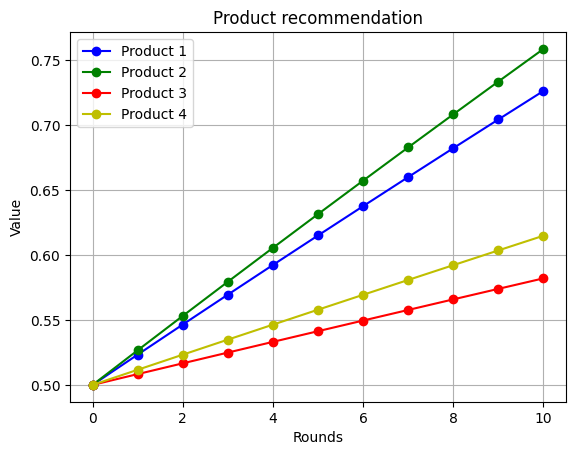

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(len(historic_models))]
p1 = [m['Product1'] for m in historic_models]
p2 = [m['Product2'] for m in historic_models]
p3 = [m['Product3'] for m in historic_models]
p4 = [m['Product4'] for m in historic_models]

plt.plot(x, p1, marker='o', linestyle='-', color='b', label='Product 1')
plt.plot(x, p2, marker='o', linestyle='-', color='g', label='Product 2')
plt.plot(x, p3, marker='o', linestyle='-', color='r', label='Product 3')
plt.plot(x, p4, marker='o', linestyle='-', color='y', label='Product 4')

plt.xlabel('Rounds')
plt.ylabel('Value')
plt.title('Product recommendation')

plt.grid(True)
plt.legend()

plt.show()